# Milestone 1

In [13]:
import torch
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [14]:
# Load dataset
df = pd.read_csv("/content/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv", sep='\t', quoting=3, on_bad_lines='skip', engine='python')

In [16]:
# Preprocessing: Selecting relevant columns
df = df[['review_body', 'star_rating']].dropna()
df['sentiment'] = df['star_rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))  # 0: Negative, 1: Neutral, 2: Positive

In [17]:
# Splitting dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review_body'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42
)

In [26]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [28]:
# Load Model (Using DistilBERT for faster training)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [31]:
# Training Setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

optimizer = optim.AdamW(model.parameters(), lr=3e-5)
loss_fn = nn.CrossEntropyLoss()

def train_epoch(model, train_loader):
    model.train()
    total_loss = 0
    correct = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        inputs.pop('token_type_ids', None)  # Remove token_type_ids for DistilBERT
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
    return total_loss / len(train_loader), correct / len(train_loader.dataset)

def evaluate(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            inputs.pop('token_type_ids', None)  # Remove token_type_ids for DistilBERT

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return acc, precision, recall, f1

In [32]:
# Training Loop
for epoch in range(3):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, F1 Score = {val_f1:.4f}")



Epoch 1: Train Loss = 0.2787, Train Acc = 0.8950, Val Acc = 0.8717, F1 Score = 0.8642
Epoch 2: Train Loss = 0.2059, Train Acc = 0.9230, Val Acc = 0.8651, F1 Score = 0.8576
Epoch 3: Train Loss = 0.1428, Train Acc = 0.9475, Val Acc = 0.8642, F1 Score = 0.8596


In [33]:
# Save Model
model.save_pretrained("/content/sentiment_model")
tokenizer.save_pretrained("/content/sentiment_tokenizer")

('/content/sentiment_tokenizer/tokenizer_config.json',
 '/content/sentiment_tokenizer/special_tokens_map.json',
 '/content/sentiment_tokenizer/vocab.txt',
 '/content/sentiment_tokenizer/added_tokens.json')

# Milestone 2

In [34]:
import torch
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [36]:
# Load dataset with error handling
df = pd.read_csv("/content/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv",
                 sep='\t',
                 quoting=3,
                 engine='python',
                 on_bad_lines='skip')  # Skips malformed lines

In [37]:
# Preprocessing: Selecting relevant columns
df = df[['review_body', 'star_rating']].dropna()
df['sentiment'] = df['star_rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))  # 0: Negative, 1: Neutral, 2: Positive

In [38]:
# Load fine-tuned model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("/content/sentiment_model")
tokenizer = DistilBertTokenizer.from_pretrained("/content/sentiment_tokenizer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [39]:
# Function to predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.argmax(outputs.logits, dim=1).cpu().item()

In [40]:
# Predict sentiments
df['predicted_sentiment'] = df['review_body'].apply(predict_sentiment)

In [41]:
# Aggregate results
sentiment_counts = Counter(df['predicted_sentiment'])
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
sentiment_counts = {sentiment_labels[k]: v for k, v in sentiment_counts.items()}

<ipython-input-42-b8e7f03b6cc5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette='viridis')


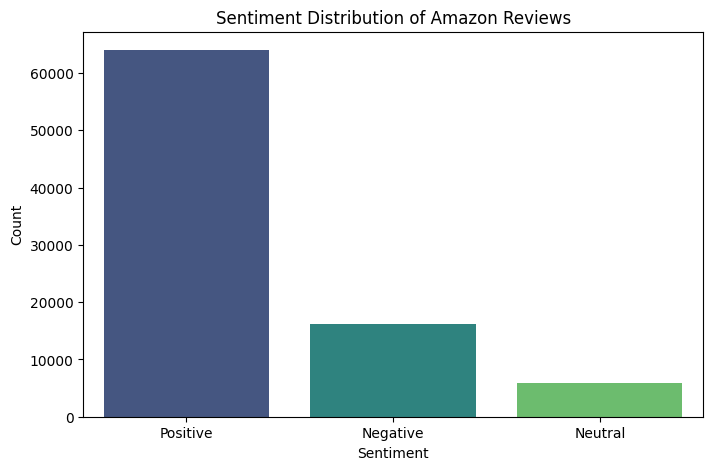

In [42]:
# Visualization
plt.figure(figsize=(8,5))
sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette='viridis')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution of Amazon Reviews")
plt.show()

In [43]:
# Save aggregated results
df.to_csv("/content/sentiment_results.csv", index=False)

# Milestone 3

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [45]:
# Load analyzed results
df = pd.read_csv('/content/sentiment_results.csv')

In [46]:
# Convert review_date to datetime (if available)
if 'review_date' in df.columns:
    df['review_date'] = pd.to_datetime(df['review_date'])

In [47]:
# Generate summary statistics
summary_stats = df['predicted_sentiment'].value_counts(normalize=True) * 100
print("Sentiment Distribution:")
print(summary_stats)

Sentiment Distribution:
predicted_sentiment
2    74.419930
0    18.778567
1     6.801503
Name: proportion, dtype: float64


In [48]:
# Save summary statistics
summary_stats.to_csv('/content/sentiment_summary.csv')

<ipython-input-54-7c0c9f04c658>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_sentiment', data=df, order=df['predicted_sentiment'].unique(), palette='coolwarm')


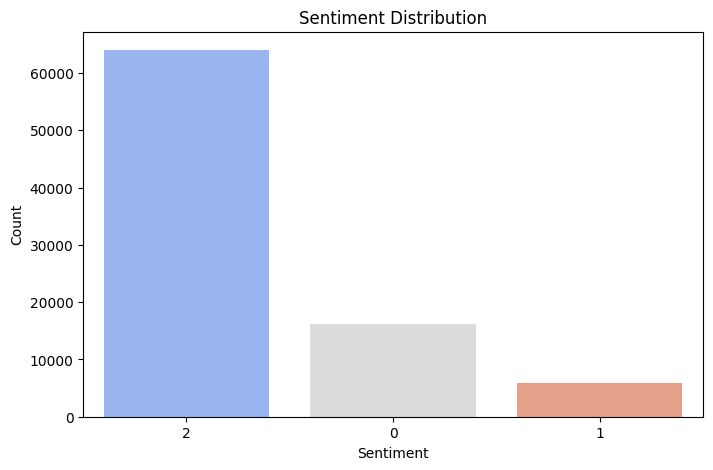

In [54]:
# Sentiment distribution
if 'predicted_sentiment' in df.columns and not df['predicted_sentiment'].empty:
    plt.figure(figsize=(8,5))
    sns.countplot(x='predicted_sentiment', data=df, order=df['predicted_sentiment'].unique(), palette='coolwarm')
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.savefig("/content/sentiment_distribution.png")
    plt.show()
else:
    print("No data available for sentiment distribution plot.")

No positive sentiment data available for word cloud.
No negative sentiment data available for word cloud.


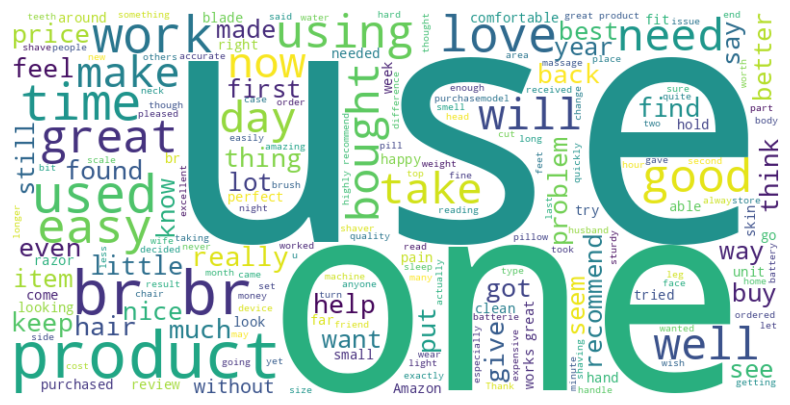

In [63]:
# Word cloud visualization
def generate_wordcloud(sentiment):
    if sentiment in df['predicted_sentiment'].unique():
        text = ' '.join(df[df['predicted_sentiment'] == sentiment]['review_body'].astype(str))
        if text.strip():
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            plt.figure(figsize=(10,5))
            plt.imshow(wordcloud, interpolation='bilinear')
            #plt.title(f"{sentiment.capitalize()} Reviews Word Cloud")
            plt.axis("off")
            plt.savefig(f"/content/wordcloud_{sentiment}.png")
            plt.show()
        else:
            print(f"No sufficient text data available for {sentiment} word cloud.")
    else:
        print(f"No {sentiment} sentiment data available for word cloud.")

generate_wordcloud('positive')
generate_wordcloud('negative')

generate_wordcloud(df['predicted_sentiment'].mode()[0])  # Generate a word cloud for the most common sentiment